# TCN LOB

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
from datetime import date, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

## Model

In [2]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(TCN, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, dilation=1, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, dilation=2, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, dilation=4, padding=4)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, dilation=8, padding=8)

        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))

        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

## Training with Seq Length

In [3]:
train_data = pd.read_csv("data/Train_NoAuction_Zscore.csv")
train_data = train_data.filter(regex=("\_+"))


test_data = pd.read_csv("data/Test_NoAuction_Zscore.csv")
test_data = test_data.filter(regex=("\_+"))

In [4]:
len(train_data)

254750

In [5]:
import numpy as np
import pandas as pd

def create_sliding_windows(data, sequence_length, feature_columns, target_column):
    features = data[feature_columns].values
    
    num_samples, num_features = features.shape

    if sequence_length >= num_samples:
        raise ValueError("sequence_length must be less than the number of samples in the data.")
    
    from numpy.lib.stride_tricks import as_strided

    X = as_strided(features, 
                   shape=(num_samples - sequence_length, sequence_length, num_features), 
                   strides=(features.strides[0], features.strides[0], features.strides[1]))
    
    y = data[target_column].values[sequence_length:]
    
    return X, y

sequence_length = 100
feature_columns = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10']).columns

target_column = 'label_1'

X, y = create_sliding_windows(train_data, sequence_length, feature_columns, target_column)

print(X.shape)
print(y.shape)

(254650, 100, 60)
(254650,)


In [7]:
batch_size=64

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_t = y_train
y_train_logits = np.zeros((len(y_t), 3))
for i in range(len(y_t)):
    y_train_logits[i, int(y_t[i]) - 1] = 1

y_v = y_val
y_val_logits = np.zeros((len(y_v), 3))
for i in range(len(y_v)):
    y_val_logits[i, int(y_v[i]) - 1] = 1


# X_train = X_train
# X_train = X_train.reshape(X_train.shape[0]//sequence_length, sequence_length, num_features)

# X_val = X_val
# X_val = X_val.reshape(X_val.shape[0]//sequence_length, sequence_length, num_features)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:

def train_model(label="label_1", batch_size=64):    
    # sample_size=4000

    
    X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_train_data = train_data[[label]]

    sequence_length = 100
    feature_columns = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10']).columns
    
    target_column = label
    
    X, y = create_sliding_windows(train_data, sequence_length, feature_columns, target_column)

    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_t = y_train
    y_train_logits = np.zeros((len(y_t), 3))
    for i in range(len(y_t)):
        y_train_logits[i, int(y_t[i]) - 1] = 1
    
    y_v = y_val
    y_val_logits = np.zeros((len(y_v), 3))
    for i in range(len(y_v)):
        y_val_logits[i, int(y_v[i]) - 1] = 1


    # X_train = X_train.values
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    
    # X_val = X_val.values
    # X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model = TCN(input_channels=sequence_length, num_classes=3)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    epochs=20
    
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
    
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # print(inputs.shape)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
    
    
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
    
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.title(f'Training and Validation Loss for label={label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    

    # X_test_data = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    # y_test_data = test_data[[label]]

    sequence_length = 100
    feature_columns = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10']).columns


    target_column = label

    X, y = create_sliding_windows(test_data, sequence_length, feature_columns, target_column)

    
    
    # y_t = y_test_data.values
    # y_test_logits = np.zeros((len(y_t), 3))
    # for i in range(len(y_t)):
    #     y_test_logits[i, int(y_t[i, 0]) - 1] = 1

    # X_test = X_test_data.values
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    X_test_tensor = torch.tensor(X, dtype=torch.float32)
    y_test_tensor = torch.tensor(y, dtype=torch.float32)
    
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            
            probabilities = model(inputs)
            
            _, predicted = torch.max(probabilities, 1)
            predicted = torch.add(predicted, 1)
            
    
            all_preds.extend(predicted.numpy())
            all_labels.extend(targets.numpy())
            
            correct_predictions += (predicted == targets.flatten()).sum().item()
            total_predictions += targets.size(0)

    print(f"correct predictions: {correct_predictions:.4f}")
    print(f"total predictions: {total_predictions:.4f}")
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy:.4f}")
    print("")
    print("")


    all_labels = np.array(all_labels)
    all_predictions = np.array(all_preds)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # print(classification_report(all_labels, all_predictions))




    return model

Epoch 1/20, Train Loss: 0.9423, Validation Loss: 0.9385
Epoch 2/20, Train Loss: 0.9381, Validation Loss: 0.9378
Epoch 3/20, Train Loss: 0.9379, Validation Loss: 0.9378
Epoch 4/20, Train Loss: 0.9377, Validation Loss: 0.9374
Epoch 5/20, Train Loss: 0.9376, Validation Loss: 0.9374
Epoch 6/20, Train Loss: 0.9375, Validation Loss: 0.9372
Epoch 7/20, Train Loss: 0.9373, Validation Loss: 0.9373
Epoch 8/20, Train Loss: 0.9371, Validation Loss: 0.9369
Epoch 9/20, Train Loss: 0.9367, Validation Loss: 0.9366
Epoch 10/20, Train Loss: 0.9363, Validation Loss: 0.9364
Epoch 11/20, Train Loss: 0.9359, Validation Loss: 0.9359
Epoch 12/20, Train Loss: 0.9354, Validation Loss: 0.9359
Epoch 13/20, Train Loss: 0.9347, Validation Loss: 0.9352
Epoch 14/20, Train Loss: 0.9341, Validation Loss: 0.9347
Epoch 15/20, Train Loss: 0.9335, Validation Loss: 0.9349
Epoch 16/20, Train Loss: 0.9328, Validation Loss: 0.9341
Epoch 17/20, Train Loss: 0.9324, Validation Loss: 0.9338
Epoch 18/20, Train Loss: 0.9318, Validat

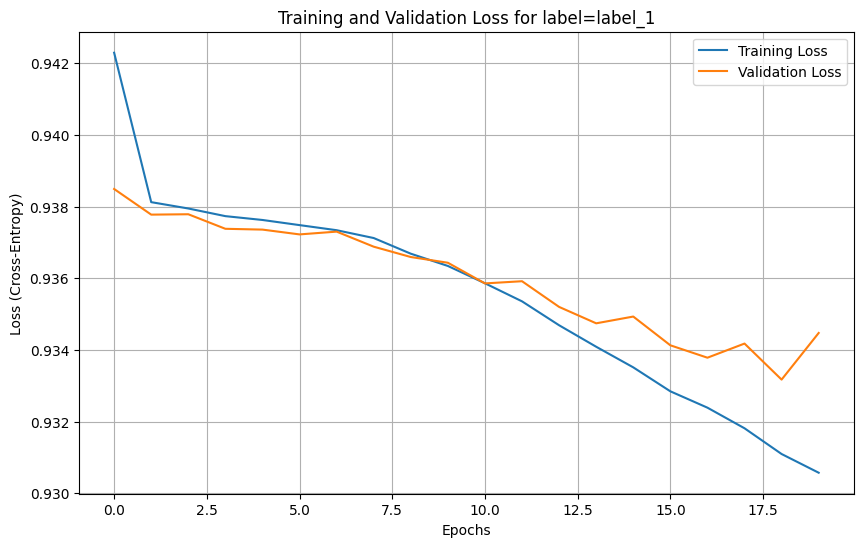

correct predictions: 98331.0000
total predictions: 139487.0000
Test Accuracy: 0.7049


Accuracy: 0.7049
Weighted Precision: 0.5940
Weighted Recall: 0.7049
Weighted F1-Score: 0.6029


In [10]:
new_tcn_model_1 = train_model(label='label_1')


# OLD - Without Seq Length

In [ ]:
# X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])[:10000]
# num_features = len(X_train_data.columns)
# y_train_data = train_data[['label_1']][:10000]


# X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

# y_t = y_train.values
# y_train_logits = np.zeros((len(y_t), 3))
# for i in range(len(y_t)):
#     y_train_logits[i, int(y_t[i, 0]) - 1] = 1

# y_v = y_val.values
# y_val_logits = np.zeros((len(y_v), 3))
# for i in range(len(y_v)):
#     y_val_logits[i, int(y_v[i, 0]) - 1] = 1


# X_train = X_train.values
# X_train = X_train.reshape(X_train.shape[0]//sequence_length, sequence_length, num_features)

# X_val = X_val.values
# X_val = X_val.reshape(X_val.shape[0]//sequence_length, sequence_length, num_features)


# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)


# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [76]:
X_train_tensor.shape

torch.Size([800, 1, 60])

In [77]:
y_train_tensor.shape

torch.Size([800, 3])

In [78]:
# Define the model
input_channels = 100
num_classes = 3

model = TCN(input_channels=input_channels, num_classes=num_classes)

# Print model summary
print(model)


TCN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  (conv4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [101]:

def train_model(label="label_1", batch_size=64):    
    # sample_size=4000

    
    X_train_data = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_train_data = train_data[[label]]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)
    
    y_t = y_train.values
    y_train_logits = np.zeros((len(y_t), 3))
    for i in range(len(y_t)):
        y_train_logits[i, int(y_t[i, 0]) - 1] = 1
    
    y_v = y_val.values
    y_val_logits = np.zeros((len(y_v), 3))
    for i in range(len(y_v)):
        y_val_logits[i, int(y_v[i, 0]) - 1] = 1
    


    X_train = X_train.values
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    
    X_val = X_val.values
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_logits, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_logits, dtype=torch.float32)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model = TCN(input_channels=1, num_classes=3)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    epochs=10
    
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
    
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # print(inputs.shape)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
    
    
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
    
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.title(f'Training and Validation Loss for label={label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend()
    
    plt.grid(True)
    plt.show()
    

    X_test_data = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_5', 'label_10'])
    y_test_data = test_data[[label]]
    
    
    # y_t = y_test_data.values
    # y_test_logits = np.zeros((len(y_t), 3))
    # for i in range(len(y_t)):
    #     y_test_logits[i, int(y_t[i, 0]) - 1] = 1

    X_test = X_test_data.values
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_data.values, dtype=torch.float32)
    
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            
            probabilities = model(inputs)
            
            _, predicted = torch.max(probabilities, 1)
            predicted = torch.add(predicted, 1)
            
    
            all_preds.extend(predicted.numpy())
            all_labels.extend(targets.numpy())
            
            correct_predictions += (predicted == targets.flatten()).sum().item()
            total_predictions += targets.size(0)

    print(f"correct predictions: {correct_predictions:.4f}")
    print(f"total predictions: {total_predictions:.4f}")
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy:.4f}")
    print("")
    print("")


    all_labels = np.array(all_labels)
    all_predictions = np.array(all_preds)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # print(classification_report(all_labels, all_predictions))




    return model

Epoch 1/10, Train Loss: 0.9432, Validation Loss: 0.9397
Epoch 2/10, Train Loss: 0.9373, Validation Loss: 0.9397
Epoch 3/10, Train Loss: 0.9371, Validation Loss: 0.9390
Epoch 4/10, Train Loss: 0.9368, Validation Loss: 0.9390
Epoch 5/10, Train Loss: 0.9365, Validation Loss: 0.9384
Epoch 6/10, Train Loss: 0.9363, Validation Loss: 0.9382
Epoch 7/10, Train Loss: 0.9359, Validation Loss: 0.9377
Epoch 8/10, Train Loss: 0.9354, Validation Loss: 0.9373
Epoch 9/10, Train Loss: 0.9349, Validation Loss: 0.9367
Epoch 10/10, Train Loss: 0.9345, Validation Loss: 0.9363


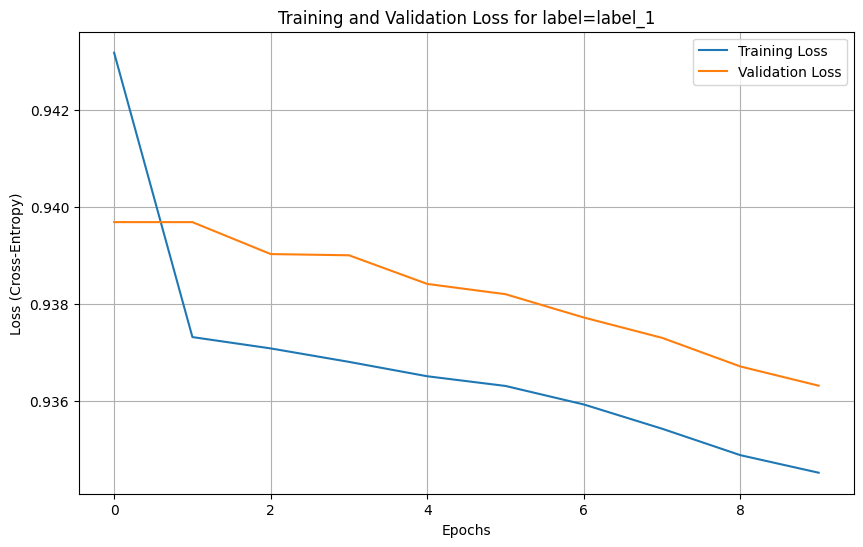

correct predictions: 98864.0000
total predictions: 139587.0000
Test Accuracy: 0.7083


Accuracy: 0.7083
Weighted Precision: 0.6184
Weighted Recall: 0.7083
Weighted F1-Score: 0.5998


In [102]:
tcn_model_1 = train_model(label='label_1')


Epoch 1/10, Train Loss: 1.0362, Validation Loss: 1.0320
Epoch 2/10, Train Loss: 1.0306, Validation Loss: 1.0311
Epoch 3/10, Train Loss: 1.0295, Validation Loss: 1.0297
Epoch 4/10, Train Loss: 1.0283, Validation Loss: 1.0283
Epoch 5/10, Train Loss: 1.0269, Validation Loss: 1.0291
Epoch 6/10, Train Loss: 1.0254, Validation Loss: 1.0265
Epoch 7/10, Train Loss: 1.0242, Validation Loss: 1.0251
Epoch 8/10, Train Loss: 1.0229, Validation Loss: 1.0247
Epoch 9/10, Train Loss: 1.0222, Validation Loss: 1.0233
Epoch 10/10, Train Loss: 1.0212, Validation Loss: 1.0222


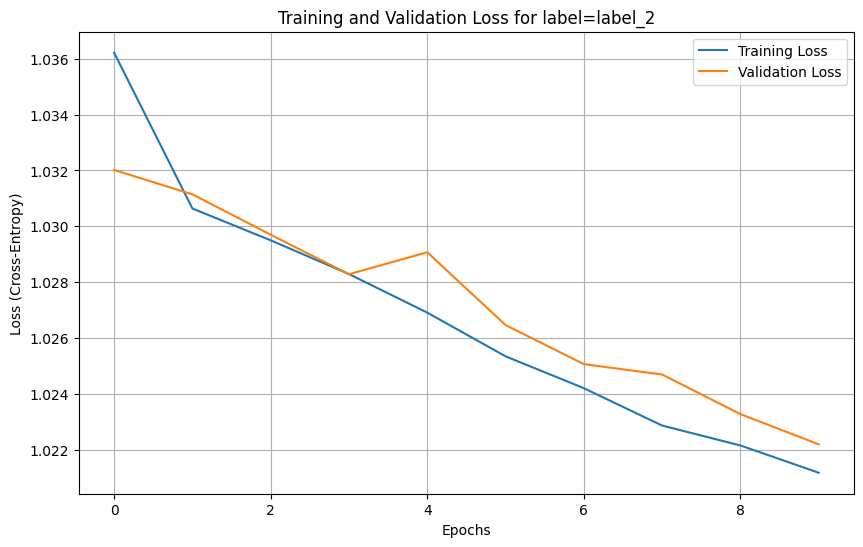

correct predictions: 86524.0000
total predictions: 139587.0000
Test Accuracy: 0.6199


Accuracy: 0.6199
Weighted Precision: 0.4593
Weighted Recall: 0.6199
Weighted F1-Score: 0.5115


/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
tcn_model_2 = train_model(label='label_2')


In [104]:
tcn_model_3 = train_model(label='label_3')


Epoch 1/10, Train Loss: 1.0735, Validation Loss: 1.0698


KeyboardInterrupt: 

In [ ]:
tcn_model_5 = train_model(label='label_5')


In [ ]:
tcn_model_10 = train_model(label='label_10')
